In [22]:
import numpy as np

# Load the .npz file
data = np.load('dataset_features.npz')

# List all arrays within the .npz file
print(data.files)

# Access individual arrays by their names
X_tr = data['trainset_features']
y_tr = data['trainset_labels']

X_val = data['validset_features']
y_val = data['validset_labels']

X_test = data['testset_features']
y_test = data['testset_labels']

class_labels = data['class_labels']

['trainset_features', 'validset_features', 'testset_features', 'trainset_labels', 'validset_labels', 'testset_labels', 'class_labels']


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), 
     ("knn", KNeighborsClassifier(n_neighbors=6))]
)

In [24]:
import pandas as pd

# [Code adapted from the previous course]
# Variable to store the results
gs_results = []

# Generate a set of k values
k_values = np.arange(1, 50, step=1)

# Grid search
for k in k_values:
    # Fit k-NN model
    knn_pipe.set_params(knn__n_neighbors=k)
    knn_pipe.fit(X_tr, y_tr)

    # Save model and its performance on training/validation sets
    gs_results.append(
        {
            "k": k,
            "train_accuracy": knn_pipe.score(X_tr, y_tr),
            "valid_accuracy": knn_pipe.score(X_val, y_val),
        }
    )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by="valid_accuracy", ascending=False).head()

,k,train_accuracy,valid_accuracy
0,1,1.000000,0.863309
6,7,0.882143,0.856115
14,15,0.850000,0.848921
8,9,0.860714,0.848921
7,8,0.850000,0.848921


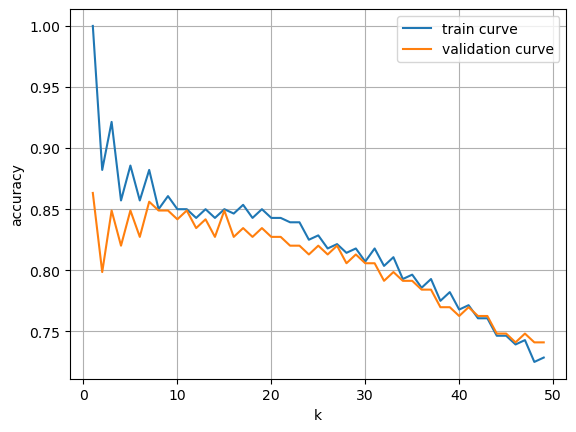

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.plot(gs_results["k"], gs_results["train_accuracy"], label="train curve")
plt.plot(gs_results["k"], gs_results["valid_accuracy"], label="validation curve")
plt.ylabel("accuracy")
plt.xlabel("k")
plt.grid(True)
plt.legend()
plt.show()

Low values of k, present high training accuracy, but in this region we're overfitting as can be seen by the accuracy gap between training and validation sets.

For higher k, both training and validation sets accuracy decreases since we're now underfitting and increasing the model variance. 

Tuned classifier that maximizes the accuracy in validation set has k=7

In [67]:
# Create a k-NN pipeline
knn_pipe_tuned = Pipeline(
    [("scaler", StandardScaler()), 
     ("knn", KNeighborsClassifier(n_neighbors=5))]
)

knn_pipe_tuned.fit(X_tr, y_tr)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

## Classification Report

In [68]:
from sklearn.metrics import classification_report

# Classification report
y_test_preds = knn_pipe_tuned.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_test_preds, target_names=class_labels))

              precision    recall  f1-score   support

        bike       1.00      1.00      1.00        12
         car       0.92      1.00      0.96        11
  motorcycle       1.00      1.00      1.00         9
       other       1.00      0.67      0.80         6
       truck       1.00      0.86      0.92         7
         van       1.00      0.80      0.89         5

   micro avg       0.98      0.92      0.95        50
   macro avg       0.99      0.89      0.93        50
weighted avg       0.98      0.92      0.94        50
 samples avg       0.92      0.92      0.92        50



/home/miguel/miniconda3/envs/adsml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: Measures the accuracy of positive predictions for each class. It is the proportion of true positives out of all instances classified as that class. 

Recall: Measures the ability of the classifier to identify all true positives for each class. It is the proportion of true positives out of all actual instances of that class. 

Support: The number of actual instances in each class. Categories like bike (33), car (32), and motorcycle (25) have a higher number of samples, which typically leads to more reliable metrics.

## Confusion Matrix

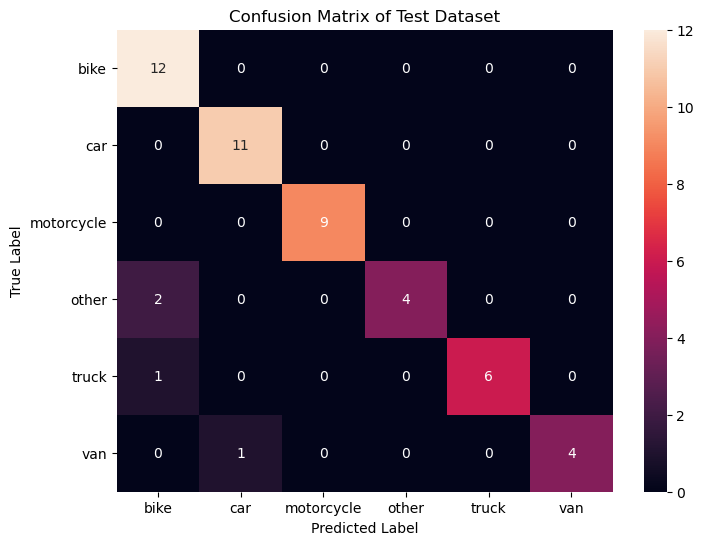

In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define class labels
class_labels = ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']

y_test_decoded = np.argmax(y_test, axis=1)
y_pred_decoded = np.argmax(y_test_preds, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Test Dataset")
plt.show()

## Correct classifications and nearest neighbours

In [70]:
import numpy as np

# Step 1: Find a correctly classified test image
correct_indices = np.where(y_test_decoded == y_pred_decoded)[0]
chosen_index = correct_indices[0]  # Choose the first correctly classified sample (or any other)

In [71]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and scaling
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)  # Adjust rescaling if needed
print('Testing set:')
test_images = datagen.flow_from_directory('./test', target_size=image_size, batch_size=batch_size, shuffle=False)

def get_image_by_index(data_flow, desired_index):

    # Calculate batch number and index within the batch
    batch_size = data_flow.batch_size
    batch_number = desired_index // batch_size + 1
    index_within_batch = desired_index % batch_size
    
    for _ in range(batch_number):
        images, labels = next(data_flow)

    image = images[index_within_batch]
    label = labels[index_within_batch]

    return image, label


Testing set:
Found 50 images belonging to 6 classes.


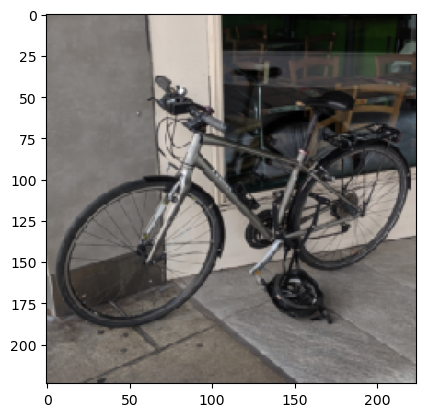

In [74]:

image, label = get_image_by_index(test_images, 0)
plt.imshow(image)

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Initialize and fit the NearestNeighbors model
neighbors_model = NearestNeighbors(n_neighbors=3, algorithm='auto')
neighbors_model.fit(X_test)

nearest_distances, nearest_indices = neighbors_model.kneighbors(X_test[chosen_index,:].reshape(1, -1), n_neighbors=10)
print(f'Nearest distances: {nearest_distances[0]}')
print(nearest_indices[0])

[ 0.       17.930384 20.015617 20.850754 21.248747 21.382458 21.704973
 21.798458 21.824482 21.994944]
[ 0  5 10 11  1 17 13 23 49 18]


TypeError: only integer scalar arrays can be converted to a scalar index

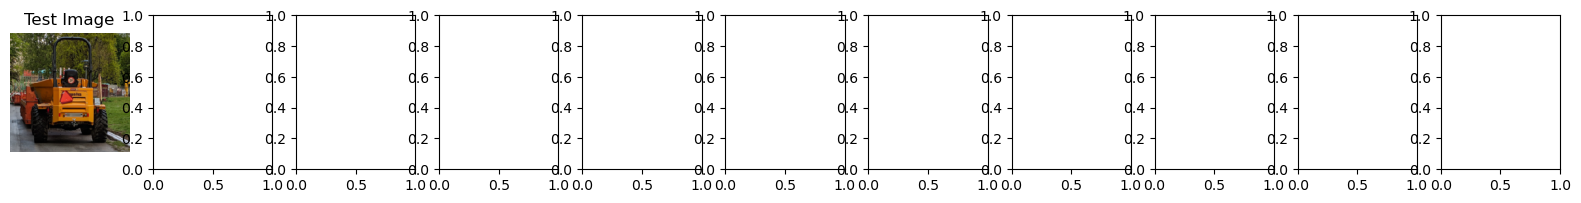

In [65]:
# Plot the chosen test image
fig, axes = plt.subplots(1, 11, figsize=(20, 2))

chosen_image, chosen_label = get_image_by_index(testset, chosen_index)
axes[0].imshow(chosen_image)
axes[0].set_title("Test Image")
axes[0].axis("off")

# Plot the 10 nearest neighbors from the training set
for i, nearest_index in enumerate(nearest_indices, start=1):
       
    nearest_image, nearest_label = get_image_by_index(testset, nearest_index)
    axes[i].imshow(nearest_image)
    axes[i].set_title(f"d: {nearest_distances[i]:.0f}")  
    axes[i].axis("off")

plt.suptitle("10 Nearest Neighbors of a Correctly Classified Test Image")
plt.show()


## Not needed!!! waiting for answer

## Cross-validation

In [ ]:
# Run several times the evaluation
gs_results = []
for run_idx in range(5):

    # Grid search
    for k in k_values:
        # Fit k-NN model
        knn_pipe.set_params(knn__n_neighbors=k)
        knn_pipe.fit(X_tr, y_tr)

        # Save model and its performance on training/validation sets
        gs_results.append(
            {
                "k": k,
                "run_idx": run_idx,
                "train_accuracy": knn_pipe.score(X_tr, y_tr),
                "valid_accuracy": knn_pipe.score(X_val, y_val),
            }
        )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)

In [ ]:
gs_results.groupby('k')

Computing of statistics of different run results

In [ ]:
# Group results by alpha value
grouped = gs_results.groupby("k")

# Compute training/validation mean scores with std
mean_tr = grouped.train_accuracy.mean()
mean_val = grouped.valid_accuracy.mean()
std_tr = grouped.train_accuracy.std()
std_val = grouped.valid_accuracy.std()

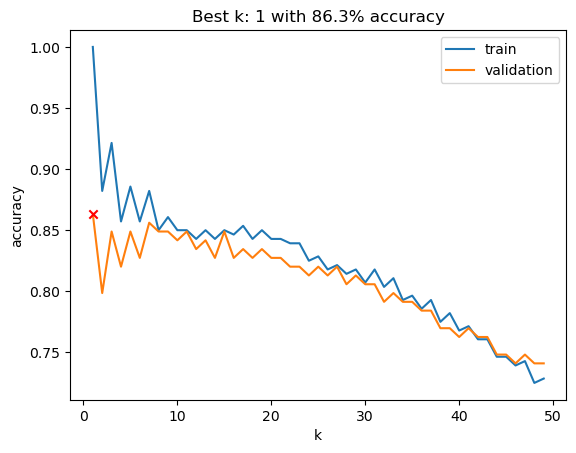

In [ ]:
# Plot mean scores
plt.plot(k_values, mean_tr, label="train")
plt.plot(k_values, mean_val, label="validation")

# Add marker for best score
best_k = mean_val.idxmax()
plt.scatter(best_k, mean_val.max(), marker="x", c="red", zorder=10)

# Quantify variance with ±std curves
plt.fill_between(k_values, mean_tr - std_tr, mean_tr + std_tr, alpha=0.2)
plt.fill_between(k_values, mean_val - std_val, mean_val + std_val, alpha=0.2)
plt.title("Best k: {} with {:.1f}% accuracy".format(best_k, 100 * mean_val[best_k]))
plt.ylabel("accuracy")
plt.xlabel("k")
plt.legend()
plt.show()